In [41]:
import torch
from torch import optim
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from torch.utils.data.dataset import Dataset
import pandas as pd
from PIL import *
%matplotlib inline
from torch.nn import functional as F
import umap

torch.manual_seed(69)    # reproducible

transformations = transforms.Compose([transforms.Scale((32,32)), transforms.Grayscale(), transforms.ToTensor()])

class SP_Images(Dataset):
    def __init__(self, csv_path, img_path, transform=transformations):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Read the csv file
        self.data_info = pd.read_csv(csv_path, header=0)
        self.img_path = img_path  # Assign image path
        self.transform = transform  # Assign transform
        self.img_names = np.asarray(self.data_info.iloc[:,0])
        self.labels = np.asarray(self.data_info.iloc[:, 1])  # Second column is the labels
        self.operation = False
        self.targets = np.asarray(self.data_info.iloc[:, 3])
        
    def __getitem__(self, index):
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.labels[index]
        # Get image name from the pandas df
        single_image_name = self.data_info.iloc[index][0]
        # Open image
        img_as_img = Image.open(self.img_path + '/' + single_image_name)
        # If there is an operation
        # Transform image to tensor
        if self.transform is not None:
            img_as_tensor = self.transform(img_as_img)
        # Return image and the label
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return len(self.data_info.index)

sp_images =  SP_Images('img_info.csv', 'images', transformations)

aa = np.empty([0])
for elem in sp_images:
    aa = np.append(aa,elem[0][0].numpy())
    
aa = np.reshape(aa, (-1,32*32))
embedding = umap.UMAP(n_neighbors=18,
                      min_dist=0.01,
                      metric='correlation').fit_transform(aa)




/home/jbl/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


4016
0.58723350414 0.513420868347


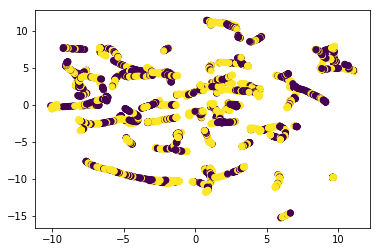

In [42]:
embedding

x = [elem[0] for elem in embedding]
y = [elem[1] for elem in embedding]

colors = sp_images.labels
targs = sp_images.targets
plt.scatter(x,y, c=colors)

print(len(embedding))

x_train = embedding[0:2500]
y_train = colors[0:2500]
y_train_reg = sp_images.targets[0:2500]
x_test = embedding[2500:]
y_test = colors[2500:]
y_test_reg = sp_images.targets[2500:]

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

names = sp_images.img_names[2500:]

clf = RandomForestClassifier(max_depth = 3)
clf.fit(x_train, y_train)
y_hat_train = clf.predict(x_train)
y_hat_test = clf.predict(x_test)
y_probs = clf.predict_proba(x_test)
df = pd.DataFrame({'names': names, 'prob_u':y_probs[:,1]})
df.to_csv('foo.csv')
print(roc_auc_score(y_train,y_hat_train),roc_auc_score(y_test,y_hat_test))

